Create a notebook configuration files that create reversible notebook histories with jsonpatch.  This notebook was originally a [gist](https://gist.github.com/tonyfast/7f75ec7eba97eb962b907e87c6e09db6).

In [1]:
from nbformat import read, v4
import json
from pathlib import Path
from jsonpatch import make_patch, JsonPatch
from time import time

`dump_site` should be configurable to the directory for the diffs.

In [2]:
dump_site = 'diffs'

__cell_source_and_type__ extracts the `source` and `cell_type` from the elements of a `list` of `cells`.

In [3]:
def cell_source_and_type(cells):
    return dict(cells=[
        dict(source=list(map('{}\n'.format, cell['source'].splitlines())), 
             cell_type=cell['cell_type']) for cell in cells.copy()])

__previous__ is a global dictionary of notebooks that are being tracked.  this value is erased each session and an initial 
notebook state is recorded.

In [4]:
previous = {}

Place the on save behavior on the `pre_save_hook` to bypass some file I/O for the notebook.

This function only operates on notebooks.  It saves a patch that can reverse the current state of the notebook back to
its initial state.  Update __previous__ with the recent notebook state each time.  With the outputs removed, the source code does not occupy significant resources

In [57]:
def pre_save_hook(model, path, contents_manager):
    global current
    if model['type'] == 'notebook':
        path = Path(path)
        
        
        name, parent = path.parts[-1].rstrip('.ipynb'), path.parent / dump_site
        
        if not path.exists() and name in previous: del previous[name]
        
        parent.exists() or parent.mkdir()
        
        current = cell_source_and_type(model['content'].copy()['cells'])        
        
        # make_patch to revert the current notebook to the previous state;
        # on the first pass store the current notebook as .0 or naught.  An initial 
        # notebook is the initial entropy S_0 of the work.
        patch = current if name not in previous else make_patch(current, previous[name]).patch
        
        # When changes are made save the patch
        if patch:
            (parent /  name).exists() or (parent /  name).mkdir()
            with (parent /  name /  '{}{}.json'.format(time(), '.0'[:2*(name not in previous)])).open('w') as f:
                json.dump(patch, f)
        
        previous[name] = current.copy()

Create the python script when we are in notebook mode.  The python script doubles as a configuration file for the notebook.  When it is imported with the notebook application assign the pre_save_hook configuration.

In [58]:
if __name__ == '__main__':
    !jupyter nbconvert --to script Untitled97.ipynb --output /Users/tonyfast/.jupyter/jupyter_notebook_config
else:
    try:
        c.FileContentsManager.pre_save_hook = pre_save_hook
    except NameError:
        ...

[NbConvertApp] Converting notebook Untitled97.ipynb to script
[NbConvertApp] Writing 5063 bytes to /Users/tonyfast/.jupyter/jupyter_notebook_config.py


Test if this work or not.

1. Load all of the __patches__ and __beginning__ state.
2. Create a __patched__ object by iterating through the patches backwrds.
3. Assert that the __patched__ notebook is __eq__ to the __beginning__ state.

In [85]:
def get_patches(path, diffspath=None):
    from fidget import a, the, flips
    def load(name):
        with name.open('r') as f: data = __import__('json').load(f)
        return data
    if diffspath is None: diffspath = dump_site
    last_init, diffs = None, []
    for diff in (Path(diffspath) / path.rstrip('.ipynb')).glob('*.json'):
        if diff.parts[-1].endswith('.0.json'):
            last_init, diffs = diff, []
        else:
            diffs.append(diff)
    return list(map(load, diffs)), load(last_init)

In [86]:
def apply_patches(patched, patches):
    for patch in patches[::-1]: 
        patched = JsonPatch(patch).apply(patched)
    return patched

In [87]:
def validate(path, diffs=None):
    """Validate that the a notebook change be patched to its original state."""
    patches, beginning = get_patches(path, diffs)
    patched = cell_source_and_type(read(path, 4).cells)
    patched = apply_patches(patched, patches)
    return make_patch(patched, beginning)

* A distribution of the changes.
* A line plot of the additions, removals, and replacements recorded.

The document was successfully reverted to its original state after __23__ saves.


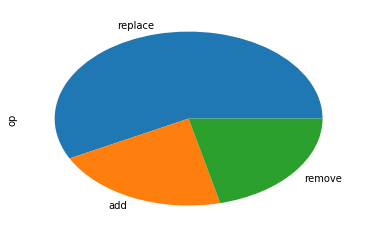

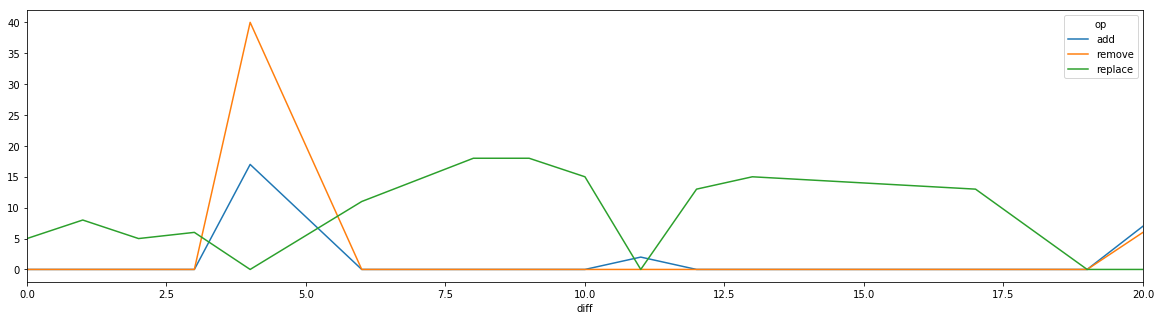

In [88]:
if __name__ == '__main__':
    assert not validate('Untitled97.ipynb').patch
    print('The document was successfully reverted to its original state after __{}__ saves.'.format(
        len(get_patches('Untitled97.ipynb')[0])))

    %matplotlib inline
    import pandas as pd; from fidget import *
    df = pd.concat(dict(enumerate(map(pd.DataFrame, get_patches('Untitled97.ipynb')[0]))))
    df.index.rename(['diff', 'change'], inplace=True)
    df.op.value_counts().plot.pie()
    df[df.value.apply(flips(dict)[isinstance])].value.apply(a.get('source').len()).sort_index().to_frame().join(df.op).pipe(
        lambda df: df.groupby([df.index.get_level_values('diff'), df.index.get_level_values('change'), df.op]).sum()
    ).unstack('change').sum(axis=1).unstack('op').fillna(0).plot(figsize=(20,5))